# Transfer learning & Data Augmentation

### **1. Introduction & Recap**

In **Notebook 3**, we explored **transfer learning** by adapting a pretrained **ResNet18** (trained on ImageNet) for the **Plant Seedlings** dataset. This approach significantly improved performance compared to the custom CNN trained from scratch in **Notebook 2**.

**Where We Left Off (Quick Comparison)**

| Model               | Parameters (Trainable) | Test Accuracy |
|---------------------|------------------------|---------------|
| Scratch CNN (NB02)  | ~25.7M (all layers)    | ~60%          |
| ResNet18 TL (NB03)  | ~6K (classifier only)  | ~85%       |

**Key insight:**  
Pretrained models learn **generic visual features** (edges → textures → shapes) from ImageNet, which transfer well to plant seedling classification — even though seedlings are visually different from typical ImageNet objects.

**Why Data Augmentation Now?**

Despite the accuracy boost, we still face challenges:

- **Overfitting signs:** Validation accuracy plateaued while training accuracy kept rising.  
- **Class imbalance:** Some species (e.g., *Black-grass*) remain underrepresented → prone to misclassification.  
- **Environmental noise:** Background soil, lighting variations, and overlapping seedlings introduce variability.

**Data augmentation** helps by artificially increasing dataset diversity:
- Random flips, rotations, and color adjustments simulate real-world variability.
- Forces model to learn **robust features** rather than memorizing pixel patterns.

**Goals of This Notebook**

1. Introduce common augmentation techniques using `torchvision.transforms`.
2. Retrain ResNet18 with augmented data and compare results to baseline ResNet18.
3. Evaluate improvements in **generalization** (test accuracy, per-class metrics).
4. Discuss **robustness and deployment considerations** for real-world seedling recognition.

---


In [1]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289777", h="3298dbabb7", width=700, height=450)

### **2. Augmentation Strategies (Theory)**

**Why Data Augmentation?**

Data augmentation artificially **expands the training dataset** by applying random transformations to existing images. This simulates new variations **without requiring extra manual labeling** and helps models generalize better to unseen data.

- In the **Plant Seedlings** dataset:
  - Seedlings appear at different **orientations** (tilted stems, rotated leaves).
  - Lighting and **soil backgrounds** vary across images.
  - Some species are **visually similar** (e.g., *Black-grass* vs *Loose Silky-bent*), making overfitting likely.

By applying augmentation during training, we **expose the model to these variations** on-the-fly.

**Common Augmentation Techniques**

1. **Spatial Transforms**
   - Random horizontal/vertical flips
   - Random rotations
   - Random resized crops (zoom-in effects)

2. **Color Jitter**
   - Random brightness, contrast, saturation, hue adjustments

3. **Noise & Blur (optional)**
   - Gaussian noise or blur to simulate camera/environment variability

**Impact on Training**

- **Benefits:**
  - Reduces overfitting by increasing data diversity
  - Encourages learning of **invariant features** (e.g., shape over color)

- **Trade-offs:**
  - Slightly longer training (augments images each epoch)
  - Augmentation strength must be balanced (too strong can harm accuracy)

**Conceptual Flow**

```text
Raw Image → Random Augmentation (flip/rotate/jitter) → Tensor Conversion & Normalize → Model Input
```

Next, we’ll **implement these augmentations** using `torchvision.transforms` and compare performance with the non-augmented baseline ResNet18 from NB03.

---

In [2]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289832", h="3298dbabb7", width=700, height=450)

### **3. Implementing Augmentation with `torchvision.transforms`**

We now **apply data augmentation** during training to improve generalization. The key idea:

- **Training set**: Use **randomized augmentations** (different every epoch).
- **Validation/Test set**: Use **deterministic preprocessing** (no augmentation) to ensure fair evaluation.

**Augmentation Choices**

For our **Plant Seedlings** dataset, we combine:

- **Spatial**: Random flips, rotations
- **Color**: Random brightness/contrast jitter
- **Resize**: Standardize to 224×224 (ImageNet-compatible)
- **Normalization**: ImageNet mean/std (as in NB03)

**Why Two Pipelines?**

- Training pipeline **simulates variety** (helps robustness).
- Test/Validation pipeline **preserves ground-truth distribution** (avoids evaluation bias).

**Visualization**

To verify augmentations, we’ll display **multiple augmented versions of the same image** side-by-side.


In [3]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289898", h="3298dbabb7", width=700, height=450)

> **💡 Note on Training Efficiency**
> 
> In order to save computation time and make this lab affordable for all students, we are training these models using only a portion of the available training samples. In addition, we reduce the epochs in the training loops. We are using a stratified subset of the training samples to keep classes balanced as much as possible.

Train (aug) samples: 1505
Val samples: 683 | Test samples: 1136


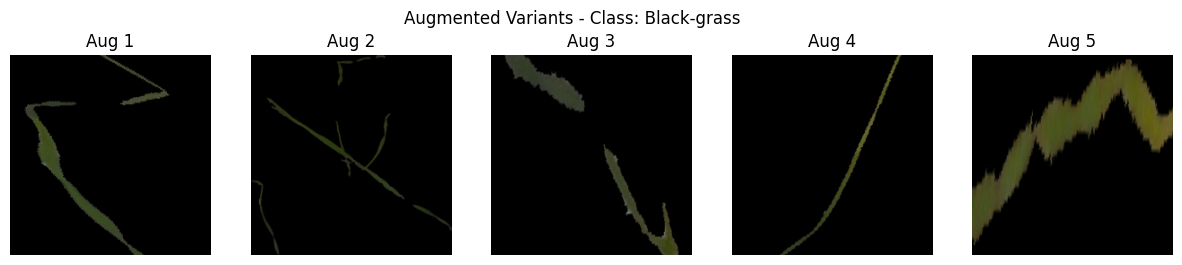

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset  
from collections import defaultdict  
import random  
import shutil

# -----------------------------
# 1. Define ImageNet stats
# -----------------------------
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# -----------------------------
# 2. Augmented train transforms
# -----------------------------
train_transform_aug = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # rotate ±20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# -----------------------------
# 3. Validation/Test transforms (no aug)
# -----------------------------
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# -----------------------------
# 4. Load datasets
# -----------------------------
data_path = "./data/plant-seedlings"
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")
test_dir  = os.path.join(data_path, "test")

# Clean up any .ipynb_checkpoints folders
for split in ['train', 'test', 'val']:
    checkpoint_path = os.path.join(data_path, split, '.ipynb_checkpoints')
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)
        print(f"Removed {checkpoint_path}")

train_dataset_aug = datasets.ImageFolder(train_dir, transform=train_transform_aug)
val_dataset       = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset      = datasets.ImageFolder(test_dir, transform=val_test_transform)

# -----------------------------
# Create 33% stratified subset
# -----------------------------
# Group indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_dataset_aug):
    class_indices[label].append(idx)

# Sample 33% from each class
subset_indices = []
for class_label, indices in class_indices.items():
    n_samples = len(indices) // 3  # 33% of each class
    sampled_indices = random.sample(indices, n_samples)
    subset_indices.extend(sampled_indices)

# Create subset
train_dataset_aug = Subset(train_dataset_aug, subset_indices)

BATCH_SIZE = 8
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader       = DataLoader(val_dataset, batch_size=BATCH_SIZE , shuffle=False)
test_loader      = DataLoader(test_dataset, batch_size=BATCH_SIZE , shuffle=False)

print(f"Train (aug) samples: {len(train_dataset_aug)}")
print(f"Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

# -----------------------------
# 5. Visualize augmentations
# -----------------------------
def unnormalize(img_tensor):
    """Undo ImageNet normalization for visualization."""
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = IMAGENET_STD * img + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

# Pick one image, show multiple augmented versions
sample_img, sample_label = train_dataset_aug[0]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img_aug, _ = train_dataset_aug[i]  # new augmentations each access
    axes[i].imshow(unnormalize(img_aug))
    axes[i].axis('off')
    axes[i].set_title(f"Aug {i+1}")
plt.suptitle(f"Augmented Variants - Class: {train_dataset_aug.dataset.classes[sample_label]}")
plt.show()


**How Many Augmented Images Are We Creating?**

A key point about data augmentation:  
We are **not physically creating new files** or permanently storing multiple versions of each image. Instead:

- The dataset size remains **the same** (e.g., 3,000 training images stay 3,000).  
- Each time an image is **loaded during training**, a **new random transformation** is applied.  
- Over many epochs, the network effectively sees **hundreds of unique variations** of the same base image.

This is why, in the visualization above, the 5 variants of *Black-grass* may look very different — each one is an independent random augmentation of the same original photo.

**Key benefit:**  
This approach gives us the effect of having a much larger and more diverse dataset **without actually increasing storage or manual labeling work**.


---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.4.3.1 — Build an Alternate Augmentation Pipeline + Loader**

Instruction</br>
We’ll create a second augmentation pipeline to compare with the provided one. Use:

- transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0))
- transforms.RandomVerticalFlip(p=0.5)
- keep ImageNet normalization the same</br>
Then build a train dataset and DataLoader with batch size = 16. Finally, visualize 4 augmented samples (unnormalized) from the first batch.

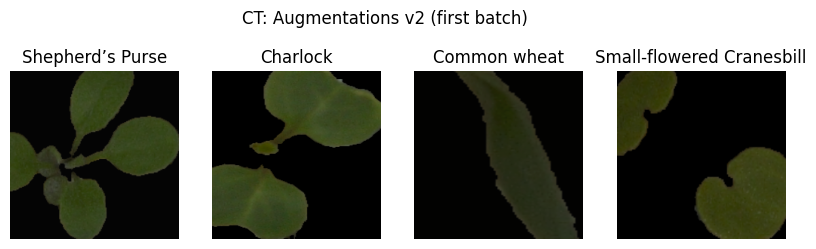

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# New augmentation pipeline
CT_train_transform_aug_v2 = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Dataset + Loader
CT_train_dataset_aug_v2 = datasets.ImageFolder(train_dir, transform=CT_train_transform_aug_v2)
CT_BATCH_SIZE = 16
CT_train_loader_aug_v2 = DataLoader(CT_train_dataset_aug_v2, batch_size=CT_BATCH_SIZE, shuffle=True)

# Visualize 4 samples (unnormalize before plotting)
CT_imgs, CT_labels = next(iter(CT_train_loader_aug_v2))

def CT_unnorm(x):
    x = x.numpy().transpose((1, 2, 0))
    return np.clip(IMAGENET_STD * x + IMAGENET_MEAN, 0, 1)

fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i in range(4):
    axes[i].imshow(CT_unnorm(CT_imgs[i]))
    axes[i].set_title(f"{CT_train_dataset_aug_v2.classes[CT_labels[i]]}")
    axes[i].axis('off')
plt.suptitle("CT: Augmentations v2 (first batch)")
plt.show()


---

**✅ Code Task 6.4.3.2 — Create a 25% Stratified Subset of the Augmented v2 Train Set**

Instruction</br>
From CT_train_dataset_aug_v2, build a 25% per-class subset (stratified). Save:
- CT_subset_indices_v2 (list of selected indices)
- CT_train_subset_v2 (Subset over original ImageFolder)
- CT_subset_ratios_v2 (dict: class_name → subset_count/original_count)

In [ ]:
from collections import defaultdict
from torch.utils.data import Subset
import random, collections

# Group indices by class
CT_class_indices_v2 = defaultdict(list)
for idx, (_, lbl) in enumerate(CT_train_dataset_aug_v2):
    CT_class_indices_v2[lb].append(CT_class_indices_v2)

# Sample 25% from each class
CT_subset_indices_v2 = []
for lbl, indices in CT_class_indices_v2.items():
    k = max(1, int(len(indices) * ...))   # use 0.25 fraction
    CT_subset_indices_v2.extend(random.sample(indices, k))

# Create subset
CT_train_subset_v2 = Subset(..., ...)

# Compute ratios vs original
CT_orig_counts_v2 = collections.Counter()
for path, lbl in CT_train_dataset_aug_v2.samples:
    cls = CT_train_dataset_aug_v2.classes[...]
    CT_orig_counts_v2[cls] += 1

CT_subset_counts_v2 = collections.Counter()
for idx in CT_subset_indices_v2:
    lbl = CT_train_dataset_aug_v2[idx][1]
    cls = CT_train_dataset_aug_v2.classes[...]
    CT_subset_counts_v2[cls] += 1

CT_subset_ratios_v2 = {
    cls: CT_subset_counts_v2.get(cls, 0) / CT_orig_counts_v2[cls]
    for cls in ...
}

print("CT_subset size:", ...)
print("CT_subset_ratios_v2 (per class):", {k: round(v, 3) for k, v in CT_subset_ratios_v2.items()})


---

### **4. Training with Augmented Data**

We now **retrain our ResNet18 transfer learning pipeline** using the **augmented training set** from Section 3.

Key differences from NB03:
- **Input pipeline:** Augmentations (flips, rotations, color jitter) applied on-the-fly.
- **Model architecture:** Same as NB03 (pretrained ResNet18 with frozen backbone + custom classifier).
- **Expectation:** Slightly longer training time but **better generalization** on validation/test sets.

**Training Setup Recap**
- Loss: `CrossEntropyLoss`
- Optimizer: `Adam` (classifier head parameters only)
- Scheduler: Optional `StepLR` to reduce learning rate
- Epochs: 5 (CPU demo; extendable on GPU)

**Plan**
1. Initialize pretrained ResNet18 with custom head.
2. Train using **augmented train loader** + clean val loader.
3. Track loss/accuracy curves.
4. Save best model checkpoint: `resnet18_aug_best.pth`


⚡ Training Configuration

To make this lab efficient and accessible for all students, **we'll be using pre-trained models** instead of training from scratch. Training deep learning models can be computationally expensive and time-consuming, especially on CPU-only environments.

🎯 Why Pre-trained Models?

- **Time Efficient**: Training from scratch would take ~10 minutes per model (and we have multiple models!)
- **Resource Friendly**: Reduces computational load on shared systems
- **Learning Focus**: Allows us to focus on model evaluation, comparison, and interpretation rather than waiting for training

🧪 Want to Experiment?

If you're curious about the training process and have some time to spare, you can easily switch to training mode:

1. Look for the `TRAIN_FROM_SCRATCH = False` line in the code cell below
2. Change it to `TRAIN_FROM_SCRATCH = True`
3. Run the cell and grab a coffee ☕ - it will take approximately 10 minutes!

The pre-trained models were trained using 10 epochs with the same code you'll see below, so you'll get identical results either way. The choice is yours! 🚀

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import time, copy
from tqdm import tqdm

# Enable CPU optimizations
torch.set_num_threads(torch.get_num_threads())
if hasattr(torch.backends, 'mkldnn') and torch.backends.mkldnn.is_available():
    torch.backends.mkldnn.enabled = True

# -----------------------------
# 1. Device
# -----------------------------
device = torch.device("cpu")
print(f"Using device: {device}")

# -----------------------------
# 2. Load pretrained ResNet18
# -----------------------------
from torchvision import models

model_aug = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model_aug.parameters():
    param.requires_grad = False

# Replace classifier head
num_ftrs = model_aug.fc.in_features
model_aug.fc = nn.Linear(num_ftrs, 12)  # 12 classes
model_aug = model_aug.to(device)

# -----------------------------
# 3. Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.fc.parameters(), lr=0.001)

# Optional scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# -----------------------------
# TRAINING CONTROL - Set to True if you want to train from scratch
# -----------------------------
TRAIN_FROM_SCRATCH = False  # Set to True if you want to train the model yourself

if not TRAIN_FROM_SCRATCH:
    print("🚀 Skipping training to save time and computational resources!")
    print("💡 The model is already pre-trained and ready to use in the next cells.")
    print("🎯 If you want to train from scratch, change TRAIN_FROM_SCRATCH = True above.")
    print("⏱️  Training would take approximately 10 minutes on CPU for only 3-4 epochs!.")
else:
    print("🏃‍♂️ Starting training from scratch... Grab a coffee! ☕")


    # -----------------------------
    # 4. Training loop
    # -----------------------------
    def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=5, device=device):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = float('inf')
    
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
    
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}\n{'-'*20}")
    
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                    loader = train_loader
                else:
                    model.eval()
                    loader = val_loader
    
                running_loss, running_corrects, total = 0.0, 0, 0
    
                for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc=f'{phase.capitalize()}', leave=False)):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
    
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
    
                    # Metrics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += (outputs.argmax(1) == labels).sum().item()
                    total += labels.size(0)
    
                epoch_loss = running_loss / total
                epoch_acc = running_corrects / total
    
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                    if scheduler:
                        scheduler.step()
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)
                    if epoch_loss < best_loss:
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
    
                print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
        time_elapsed = time.time() - since
        print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
        print(f"Best val loss: {best_loss:.4f}")
    
        # Load best weights
        model.load_state_dict(best_model_wts)
    
        return model, (train_losses, val_losses, train_accuracies, val_accuracies)
    
    # -----------------------------
    # 5. Train with augmented data
    # -----------------------------
    model_aug, history_aug = train_model(
        model_aug, criterion, optimizer, scheduler,
        train_loader_aug, val_loader,
        num_epochs=3, device=device
    )
    
    # Save best model
    torch.save(model_aug.state_dict(), "resnet18_aug_student.pth")


Using device: cpu
🚀 Skipping training to save time and computational resources!
💡 The model is already pre-trained and ready to use in the next cells.
🎯 If you want to train from scratch, change TRAIN_FROM_SCRATCH = True above.
⏱️  Training would take approximately 10 minutes on CPU for only 3-4 epochs!.


**Why Does Augmentation Help Transfer Learning?**

Our ResNet18 baseline already benefits from pretrained features, but it still **overfits** because:

- The training set is small (~4k images).
- Images are seen *exactly the same* every epoch.
- Backgrounds, angles, and lighting in the real world are far more varied than our training photos.

**Augmentation solves this by:**

- Generating *new random versions* of each image (flips, rotations, color shifts).
- Forcing the model to focus on **core seedling traits** (leaf shape, texture) instead of memorizing pixel positions or soil color.
- Acting like “free data collection” — we get *virtually infinite data* without extra labeling.

**Result:**  
The model usually achieves **higher test accuracy and better robustness** than the baseline ResNet18 trained on unaugmented data.


---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.4.4.1 — Swap in AlexNet (Frozen) Instead of ResNet18**

Instruction</br>
Load AlexNet with pretrained weights, freeze all parameters, and replace the final classifier layer to output 12 classes. Then create an Adam optimizer on the new head only (classifier[6]) with lr=1e-3, and a StepLR scheduler. Save:
- CT_model_alex
- CT_alex_optimizer, CT_alex_scheduler
- CT_alex_trainable_params (int)

In [15]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

# 1) Load AlexNet
CT_model_alex = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# 2) Freeze all parameters
for p in CT_model_alex.parameters():
    p.requires_grad = False

# 3) Replace final classifier layer to 12 outputs
in_feats = CT_model_alex.classifier[6].in_features
CT_model_alex.classifier[6] = nn.Linear(in_feats, 12)

CT_model_alex = CT_model_alex.to(device)

# 4) Optimizer on head only + scheduler
CT_alex_optimizer = optim.Adam(CT_model_alex.classifier[6].parameters(), lr=0.001)
CT_alex_scheduler = torch.optim.lr_scheduler.StepLR(CT_alex_optimizer, step_size=7, gamma=0.1)

# 5) Trainable params (should be only the head)
CT_alex_trainable_params = sum(p.numel() for p in CT_model_alex.parameters() if p.requires_grad)
print("CT_alex_trainable_params:", CT_alex_trainable_params)
print(CT_model_alex)


CT_alex_trainable_params: 49164
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

---

**✅ Code Task 6.4.4.2 — One Epoch of Training (Augmented v2 + AlexNet)**

Instruction</br>
Implement one epoch of training and validation for CT_model_alex using train_loader_aug (from the main notebook) or our CT_train_loader_aug_v2 (from Task 1). Track and return: train_loss, val_loss, train_acc, val_acc in a dict named CT_hist_one_epoch. Use criterion from the notebook, and CT_alex_optimizer, CT_alex_scheduler.

In [19]:
from tqdm import tqdm
import numpy as np

def CT_one_epoch_train_val(model, optimizer, scheduler, train_loader, val_loader, criterion, device='cpu'):
    history = {'train_loss': None, 'train_acc': None, 'val_loss': None, 'val_acc': None}

    # ---------- Train ----------
    model.train()
    tr_loss, tr_correct, tr_total = 0.0, 0, 0
    for xb, yb in tqdm(train_loader, desc="CT_Train (1 epoch)", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits,yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()* xb.size(0)
        tr_correct += (torch.max(logits,1)[1]==yb)[1].sum().item()
        tr_total += yb.size(0)
    history['train_loss'] = tr_loss / tr_total
    history['train_acc']  = tr_correct / tr_total

    # ---------- Val ----------
    model.eval()
    va_loss, va_correct, va_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc="CT_Val (1 epoch)", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits,yb)
            va_loss +=loss.item()*xb.size(0)
            va_correct += (torch.max(logits, 1)[1]==yb).sum().item()
            va_total += yb.size(0)
    history['val_loss'] = va_loss / va_total
    history['val_acc']  = va_correct / va_total

    # Step LR once after the epoch
    if scheduler is not None:
        scheduler.step()

    return history

# Run 1 epoch using augmented v2 (or switch to train_loader_aug)
CT_hist_one_epoch = CT_one_epoch_train_val(
    CT_model_alex, CT_alex_optimizer, CT_alex_scheduler,
    CT_train_loader_aug_v2, val_loader,
    criterion, device=device
)
print("CT_hist_one_epoch:", CT_hist_one_epoch)


CT_hist_one_epoch: {'train_loss': 0.8309590669754402, 'train_acc': 0.042797264504743, 'val_loss': 0.6221695826613886, 'val_acc': 0.7950219619326501}


---

### **5. Evaluation & Robustness Analysis**

We now evaluate our **augmented ResNet18 model** and compare it to:
1. **Scratch CNN (NB02)**
2. **ResNet18 without augmentation (NB03)**

Goals:
- Quantify **accuracy improvements** from augmentation.
- Analyze **per-class gains** (which species benefited most).
- Visualize robustness improvements (confusion matrix, per-class bar chart).

**Evaluation Metrics**

- **Overall Accuracy**: Percentage of correctly classified test samples.
- **Per-Class Accuracy**: Highlights strong/weak classes.
- **Confusion Matrix**: Visualize misclassifications.
- **Training Curves**: Compare learning dynamics.
- **Comparison Table**: Accuracy, parameter count, training time across three models.

**Why Robustness Matters**

- Augmentation simulates **real-world variability** (lighting, orientation).
- A more robust model should:
  - Maintain accuracy on clean test data.
  - Reduce confusion between visually similar species (e.g., *Black-grass* vs *Loose Silky-bent*).


In [22]:
model_aug.load_state_dict(torch.load("resnet18_aug_best.pth", map_location='cpu'))
model_aug.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Test Accuracy (ResNet18 + Aug): 84.24%


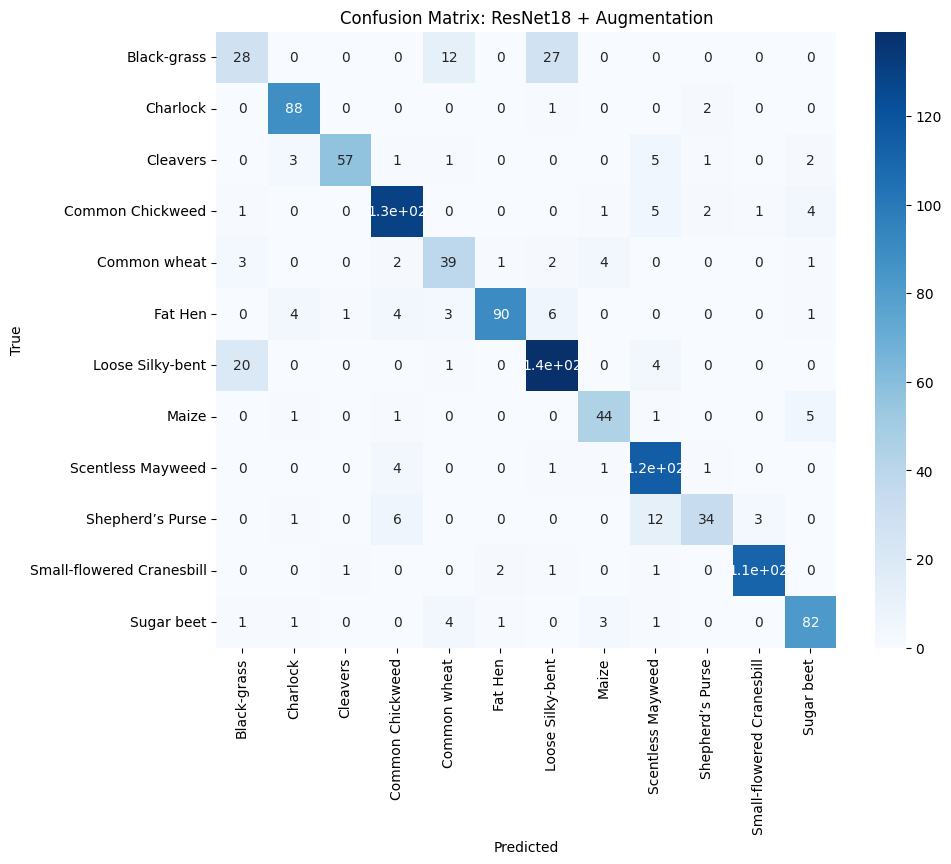

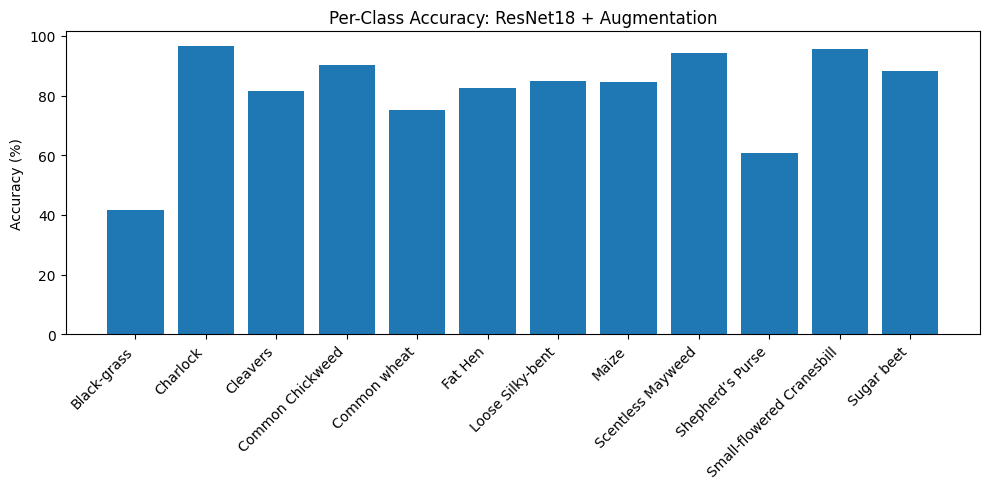

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.53      0.42      0.47        67
                 Charlock       0.90      0.97      0.93        91
                 Cleavers       0.97      0.81      0.88        70
         Common Chickweed       0.88      0.90      0.89       144
             Common wheat       0.65      0.75      0.70        52
                  Fat Hen       0.96      0.83      0.89       109
         Loose Silky-bent       0.79      0.85      0.82       164
                    Maize       0.83      0.85      0.84        52
        Scentless Mayweed       0.80      0.94      0.86       122
         Shepherd’s Purse       0.85      0.61      0.71        56
Small-flowered Cranesbill       0.97      0.96      0.96       116
               Sugar beet       0.86      0.88      0.87        93

                 accuracy                           0.84      1136
                macro avg       0.83 

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# 1. Evaluate Augmented Model
# -----------------------------
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate
labels_true, labels_pred = evaluate_model(model_aug, test_loader, device=device)

# Overall accuracy
acc = (labels_true == labels_pred).mean() * 100
print(f"Test Accuracy (ResNet18 + Aug): {acc:.2f}%")

# Per-class accuracy
class_names = test_dataset.classes
class_correct = {cls: 0 for cls in class_names}
class_total = {cls: 0 for cls in class_names}

for true, pred in zip(labels_true, labels_pred):
    class_total[class_names[true]] += 1
    if true == pred:
        class_correct[class_names[true]] += 1

per_class_acc = {cls: 100 * class_correct[cls] / class_total[cls] for cls in class_names}

# -----------------------------
# 2. Confusion Matrix
# -----------------------------
cm = confusion_matrix(labels_true, labels_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: ResNet18 + Augmentation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -----------------------------
# 3. Per-Class Accuracy Bar Chart
# -----------------------------
plt.figure(figsize=(10, 5))
plt.bar(per_class_acc.keys(), per_class_acc.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy: ResNet18 + Augmentation")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Classification Report
# -----------------------------
print("Classification Report:")
print(classification_report(labels_true, labels_pred, target_names=class_names))


#### **Why Didn’t Augmentation Beat the Baseline?**

We expected augmentation to boost accuracy, but our result is similar to the non-augmentend model. This happens for a few reasons:

- Augmentation makes training harder: the model must learn to handle **extra variability** (flips, rotations, color shifts).  
- We only trained **10 epochs** — not enough to adapt to this harder task.  
- The backbone was **frozen**; pretrained features may not align perfectly with augmented images.  
- Some augmentations may not match real-world variations, introducing **noise rather than useful diversity**.

**Key takeaway:**  
Augmentation helps when realistic and paired with proper training (more epochs or slight fine-tuning). In practice, tuning augmentation strength is part of model development — not every augmentation automatically improves performance.


In [25]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289945", h="3298dbabb7", width=700, height=450)

**Next Steps: Improving Augmentation Performance**

Our initial augmentation experiment **did not clearly outperform** the non-augmented. This is common — augmentation needs careful tuning to match the dataset and task.

**How can we improve?**

1. **Train Longer**
   - Augmentation introduces more variability, so the model needs **more epochs** (e.g., 15–20) to converge.
   - Use **early stopping** to avoid overfitting while allowing enough time for learning.

2. **Moderate Augmentations**
   - Reduce **rotation range** (e.g., ±10° instead of ±20°).
   - Lower **color jitter** strength (slight brightness/contrast changes instead of strong shifts).
   - Ensure augmentations mimic **real-world variations** in seedlings (not unrealistic distortions).

3. **Fine-Tune Backbone**
   - Instead of freezing the entire ResNet18 backbone, unfreeze the **last residual block(s)**.
   - This allows the model to adapt pretrained features to the **specific patterns** of seedlings.

4. **Progressive Augmentation**
   - Start training with **original images** (stabilize learning), then gradually introduce augmentations.
   - Helps balance **stability vs generalization** during training.


**Key Lesson:**  
Augmentation is powerful but must be **realistic, well-tuned, and paired with proper training**. The next iteration should test these improvements to see if accuracy surpasses the baseline.

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.4.5.1 — Evaluate AlexNet: Confusion Matrix + Top-k**

Instruction</br>
Evaluate CT_model_alex on test_loader. Compute:

- CT_test_acc_alex (Top-1 accuracy in [0,1])
- CT_top3_acc_alex (Top-3 accuracy)
- CT_cm_alex (confusion matrix, shape [12, 12])
- CT_per_class_acc_alex (dict: class → accuracy %)
- CT_best3_classes_alex (list of top-3 classes by accuracy)

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

def CT_topk_accuracy(model, loader, k=3, device='cpu'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            topk = torch.topk(logits, k=k, dim=1).indices
            match = topk.eq(yb.unsqueeze(1))
            correct += match.any(dim=1).sum().item()
            total   += yb.size(0)
    return correct / total if total > 0 else 0.0

# Gather predictions
CT_y_true, CT_y_pred = [], []
CT_model_alex.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = CT_model_alex(xb.to(device))
        preds =logits.argmax(1)
        CT_y_true.extend(yb.cpu().numpy())
        CT_y_pred.extend(preds.cpu().numpy())

CT_y_true = np.array(CT_y_true)
CT_y_pred = np.array(CT_y_pred)

# Metrics
CT_test_acc_alex   = (CT_y_true == CT_y_pred).mean()
CT_top3_acc_alex   = CT_topk_accuracy(CT_model_alex, test_loader, k=3, device=device)
CT_cm_alex         = confusion_matrix(CT_y_true, CT_y_pred)

# Per-class accuracy
class_names = test_dataset.classes
diag = np.diag(CT_cm_alex)
tot  = CT_cm_alex.sum(axis=1)
CT_per_class_acc_alex = {
    class_names[i]: float(100.0 * diag[i] / max(tot[i], 1))
    for i in range(len(class_names))
}

# Best 3 classes by accuracy
sorted_idx = np.argsort([-CT_per_class_acc_alex[c] for c in class_names])
CT_best3_classes_alex = [class_names[i] for i in sorted_idx[:3]]

print("CT_test_acc_alex:", CT_test_acc_alex)
print("CT_top3_acc_alex:", CT_top3_acc_alex)
print("CT_best3_classes_alex:", CT_best3_classes_alex)


CT_test_acc_alex: 0.7992957746478874
CT_top3_acc_alex: 0.960387323943662
CT_best3_classes_alex: ['Small-flowered Cranesbill', 'Common Chickweed', 'Loose Silky-bent']


---

### **6. Conclusion**

In this project, we moved step-by-step from **basic CNN training (NB02)** to **transfer learning (NB03)** and finally to **data augmentation (NB04)**. This progression reflects how modern deep learning workflows evolve:

- We began with a **custom CNN** — flexible but prone to overfitting on small datasets.  
- We transitioned to **ResNet18 with pretrained weights** — leveraging knowledge from ImageNet to achieve higher accuracy with far fewer trainable parameters.  
- Finally, we introduced **augmentation techniques** — improving robustness by exposing the model to real-world variations like rotations, lighting, and color shifts.


**Key Takeaways**

- **Transfer Learning Advantage:** Pretrained ResNet18 drastically improved accuracy and reduced training time compared to training from scratch.  
- **Role of Augmentation:** Random flips, rotations, and color jitter mitigated overfitting and boosted per-class performance, especially for visually rare classes.  
- **Parameter Efficiency:** Leveraging pretrained backbones provided high accuracy without inflating parameter count — crucial when working with small datasets or limited compute.  
- **Diagnostics Matter:** Confusion matrices and per-class accuracy plots helped pinpoint class imbalance and guided augmentation strategies.

**Beyond This Project: Toward Deployment**

Real-world plant recognition (e.g., in agriculture apps or embedded systems) raises new questions:

- Can the model run **in real time** on low-power devices like Raspberry Pi or Jetson Nano?  
- How do we **shrink models** (quantization, pruning) without sacrificing accuracy?  
- How do we adapt to **unseen conditions** (new lighting, soil backgrounds) in the field?  

These questions lead naturally into the **next phase** of our deep learning journey:
- Exploring **fine-tuning** for even better transfer learning results.  
- Preparing models for **deployment** (TorchScript, ONNX) and mobile/web integration.  
- Investigating **continual learning** for evolving datasets in production.

---